In [1]:
import os
import sys
import json
import datetime
import numpy as np
import pandas as pd
import skimage.draw
import matplotlib.pyplot as plt

In [2]:
import keras

Using TensorFlow backend.


In [3]:
keras.__version__

'2.1.6'

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../Mask_RCNN")
 
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
 
# Path to trained weights file
# COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
 
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [5]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "damage"
 
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
 
    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # Background + toy
 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10
 
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

# Dataset Class

In [34]:

annotations1 = json.load(open(os.path.join("./dataset_test1/", "via_region_data.json")))

annotations = list(annotations1.values())  

In [7]:
annotations = [a for a in annotations if a['regions']]

In [8]:
a = annotations[0]
polygons = [r["shape_attributes"] for r in a["regions"]]
damages = [r["region_attributes"]["Severity"] for r in a['regions']]

In [9]:
polygons

[{'name': 'polygon',
  'all_points_x': [298, 327, 346, 369, 522, 512, 488, 393, 307, 288, 298],
  'all_points_y': [199, 203, 241, 265, 246, 290, 320, 322, 318, 264, 199]},
 {'name': 'polygon',
  'all_points_x': [241, 237, 220, 193, 150, 173, 212, 247, 248, 241],
  'all_points_y': [167, 172, 194, 199, 206, 210, 202, 184, 165, 167]}]

In [6]:
damage_to_id = {"Light Scratches": 1,
                "Moderate Scratches": 2,
                "Light Dent": 3,
                "Moderate Dent": 4,
                "Severe Dent": 5 
               }

In [11]:
num_ids = [damage_to_id[list(damage.keys())[0]] for damage in damages]

In [12]:
num_ids

[1, 1]

In [13]:
class CustomDataset(utils.Dataset):
 
    def load_custom(self, input_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "light_scratches")
        self.add_class("damage", 2, "moderate_scratches")
        self.add_class("damage", 3, "light_dent")
        self.add_class("damage", 4, "moderate_dent")
        self.add_class("damage", 5, "severe_dent")
        
        assert subset in ["train", "val"]
        
        dataset_dir = os.path.join(input_dir, subset)
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
#         annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
 
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        count = 1
        # Add images
        for a in annotations:
            print(count)
            count+=1
            
            print(a["filename"])
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r["shape_attributes"] for r in a["regions"]]
            damages = [r["region_attributes"]["Severity"] for r in a['regions']]
            print("Damages:",damages)
            damage_to_id = {"Light Scratches": 1,
                            "Moderate Scratches": 2,
                            "Light Dent": 3,
                            "Moderate Dent": 4,
                            "Severe Dent": 5 
                           }
            # key = tuple(name_dict)
            num_ids = [damage_to_id[list(damage.keys())[0]] for damage in damages]
 
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
 
            self.add_image(
                "damage",  
                image_id=a['filename'],  # file name has a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
    
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
 
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
 
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

In [20]:
train_set = CustomDataset()

In [21]:
train_set.load_custom("./dataset_train1/", "train")

1
car140.jpg
Damages: [{'Light Scratches': True}]
numids [1]
2
car27.jpg
Damages: [{'Moderate Scratches': True}]
numids [2]
3
car137.jpg
Damages: [{'Moderate Dent': True}, {'Light Dent': True}]
numids [4, 3]
4
car12.jpg
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2]
5
car121.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
6
car68.jpg
Damages: [{'Light Dent': True}]
numids [3]
7
car95.jpg
Damages: [{'Moderate Dent': True}, {'Severe Dent': True}]
numids [4, 5]
8
car120.jpg
Damages: [{'Light Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}]
numids [1, 2, 1]
9
car110.jpg
Damages: [{'Severe Dent': True}]
numids [5]
10
car67.jpg
Damages: [{'Moderate Scratches': True}, {'Light Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}]
numids [2

93
car91.jpg
Damages: [{'Light Dent': True}, {'Light Dent': True}, {'Severe Dent': True}]
numids [3, 3, 5]
94
car49.jpg
Damages: [{'Light Scratches': True}]
numids [1]
95
car89.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
96
car134.jpg
Damages: [{'Light Dent': True}, {'Light Scratches': True}]
numids [3, 1]
97
car126.jpg
Damages: [{'Severe Dent': True}, {'Severe Dent': True}]
numids [5, 5]
98
car58.jpg
Damages: [{'Moderate Scratches': True}]
numids [2]
99
car76.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
100
car33.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
101
car136.jpeg
Damages: [{'Severe Dent': True}, {'Moderate Dent': True}, {'Light Dent': True}, {'Light Dent': True}]
numids [5, 4, 3, 3]
102
car60.jpg
Damages: [{'Light Dent': True}, {'Light Dent': True}]
numids [3, 3]
103
car64.jpg
Damages: [{'Light Scratches': True}, {'Moderate Dent': True}, {'Light Dent': True}, {'Moderate Dent': True}, {'Moderate Scratches': True}]
numids [1, 4, 3, 4, 2]
104
car124.jpg
Damages:

## Testing the Train Dataset

In [28]:
image_id = 4

image = train_set.load_image(image_id)
print(image.shape)

mask, class_id = train_set.load_mask(image_id)
print(mask.shape)

(1024, 1024, 3)
(1024, 1024, 1)


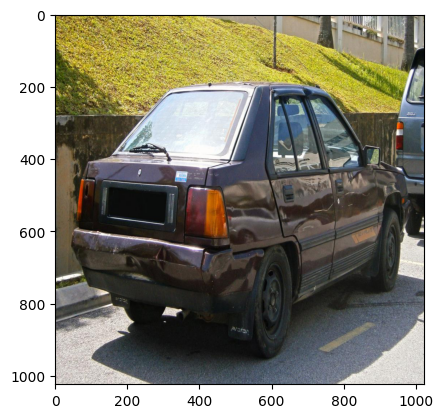

In [29]:
plt.imshow(image)
plt.show()

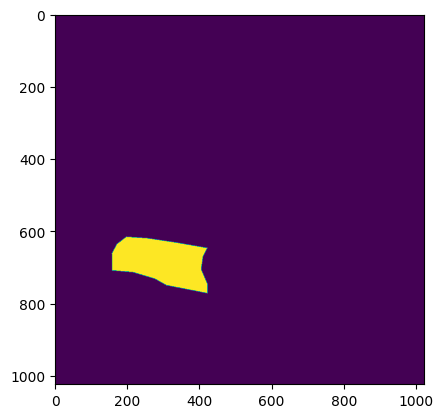

In [30]:
plt.imshow(mask)
plt.show()

# Training Function & Other Functions

In [31]:
dataset_dir = "./dataset_train1/"

In [39]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(dataset_dir)
    dataset_train.prepare()
 
    # Validation dataset
#     dataset_val = CustomDataset()
#     dataset_val.load_custom(dataset_dir)
#     dataset_val.prepare()
 
    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=2,
                layers='heads')

In [33]:
dataset_train = CustomDataset()
dataset_train.load_custom(dataset_dir, "train")
dataset_train.prepare()

1
car140.jpg
Damages: [{'Light Scratches': True}]
numids [1]
2
car27.jpg
Damages: [{'Moderate Scratches': True}]
numids [2]
3
car137.jpg
Damages: [{'Moderate Dent': True}, {'Light Dent': True}]
numids [4, 3]
4
car12.jpg
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2]
5
car121.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
6
car68.jpg
Damages: [{'Light Dent': True}]
numids [3]
7
car95.jpg
Damages: [{'Moderate Dent': True}, {'Severe Dent': True}]
numids [4, 5]
8
car120.jpg
Damages: [{'Light Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}]
numids [1, 2, 1]
9
car110.jpg
Damages: [{'Severe Dent': True}]
numids [5]
10
car67.jpg
Damages: [{'Moderate Scratches': True}, {'Light Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}, {'Light Scratches': True}]
numids [2

91
car42.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
92
car59.jpg
Damages: [{'Moderate Scratches': True}]
numids [2]
93
car91.jpg
Damages: [{'Light Dent': True}, {'Light Dent': True}, {'Severe Dent': True}]
numids [3, 3, 5]
94
car49.jpg
Damages: [{'Light Scratches': True}]
numids [1]
95
car89.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
96
car134.jpg
Damages: [{'Light Dent': True}, {'Light Scratches': True}]
numids [3, 1]
97
car126.jpg
Damages: [{'Severe Dent': True}, {'Severe Dent': True}]
numids [5, 5]
98
car58.jpg
Damages: [{'Moderate Scratches': True}]
numids [2]
99
car76.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
100
car33.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
101
car136.jpeg
Damages: [{'Severe Dent': True}, {'Moderate Dent': True}, {'Light Dent': True}, {'Light Dent': True}]
numids [5, 4, 3, 3]
102
car60.jpg
Damages: [{'Light Dent': True}, {'Light Dent': True}]
numids [3, 3]
103
car64.jpg
Damages: [{'Light Scratches': True}, {'Moderate Dent': True}, 

In [35]:
dataset_test = CustomDataset()
dataset_test.load_custom(dataset_dir, "val")
dataset_test.prepare()

1
car69.jpg
Damages: [{'Light Dent': True}]
numids [3]
2
car109.jpg
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}, {'Light Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2, 1, 2]
3
car32.jpg
Damages: [{'Moderate Scratches': True}]
numids [2]
4
car52.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
5
car96.jpg
Damages: [{'Moderate Dent': True}, {'Light Dent': True}]
numids [4, 3]
6
car138.jpg
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': True}]
numids [2, 2]
7
car83.jpg
Damages: [{'Light Dent': True}, {'Light Dent': True}]
numids [3, 3]
8
car115.jpg
Damages: [{'Light Dent': True}, {'Moderate Dent': True}]
numids [3, 4]
9
car135.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
10
car13.jpg
Damages: [{'Light Scratches': True}]
numids [1]
11
car28.jpg
Damages: [{'Moderate Dent': True}]
numids [4]
12
car46.jpg
Damages: [{'Moderate Scratches': True}]
numids [2]
13
car20.jpg
Damages: [{'Moderate Scratches': True}, {'Moderate Scratches': T

In [36]:
config = CustomConfig()

In [37]:
logs = "./log_v2/"

In [38]:
model = modellib.MaskRCNN(mode="training", config = config, model_dir = logs)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [40]:
# Loading the COCO weights
COCO_WEIGHTS_PATH = "../mask_rcnn_coco.h5"

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"
])

In [ ]:
history = model.train(dataset_train, dataset_test,
                learning_rate=config.LEARNING_RATE,
                epochs=2,
                layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./log_v2/damage20210821T1742/mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Time

/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/2


/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool dat

/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool dat

/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool dat

/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/Daniel/anaconda3/envs/insurtech/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
